# Time series classification for dropout prediction

We adopt the time series classification methodology presented in the work of Liu et
al. {cite}`liu_2018` for student dropout prediction.

Time-series classifiers can effectively visualize and categorize data based on
pattern similarities, enabling them to learn distinctive series of behaviors,
distinguishing dropout from retention.

The classification approach uses student interaction data (click-stream) on
different resource types ('resource', 'content' and 'forumng').
Where 'oucontent' and 'resource' refer to a lecture video and a segment of text
students are supposed to watch or read, and 'forumng' points to the forum space of
the course.

A student is considered a dropout if he withdraws from a course.
In the OULAD dataset, this information is recorded with a `Withdrawn` value in the
`final_result` column of the `student_info` table.

The authors rearranged the OULAD interaction data and transformed it into several
time series using the following steps:

1. Extract the number of clicks the students make on the three types of material and
   group them by course module presentation.
2. Sum up the number of clicks each student makes on each type of material from each
   presentation daily.
3. Align each student’s total clicks on each type of material by days.
4. Add the dropout label, withdrawn as `1`, otherwise as `0`, to the end of each
   student instance.

Thus, three time-series datasets are constructed for each course module presentation.

Finally, student dropout is predicted by applying a Time series forest classifier on
each time series by course.

```{bibliography}
:filter: docname in docnames
```

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Markdown, display
from pyts.classification import TimeSeriesForest
from sklearn.model_selection import cross_val_score

from oulad import get_oulad

oulad = get_oulad()

## Dropout rate by course presentation

As we embark on the task of student dropout classification, it's important to first
familiarize ourselves with some basic descriptive statistics about the dataset.
As demonstrated in the work of Lui et al., a concise summary of domain information
and relevant statistics regarding student dropout in diverse course modules can prove
insightful.
We shall attempt to replicate this table in our present study.

In [2]:
display(
    # Add code_module, code_presentation, module_presentation_length columns.
    oulad.courses
    # Add domain column.
    .merge(oulad.domains, on="code_module")
    # Add days column.
    .merge(
        oulad.student_vle[oulad.student_vle.date < 0]
        .groupby(["code_module", "code_presentation"])["date"]
        .min()
        .reset_index(),
        on=["code_module", "code_presentation"],
    )
    .assign(days=lambda df: df.module_presentation_length - df.date + 1)
    # Add id_student and final_result columns.
    .merge(
        oulad.student_info[
            ["id_student", "code_module", "code_presentation", "final_result"]
        ],
        on=["code_module", "code_presentation"],
    )
    .assign(final_result=lambda df: df.final_result == "Withdrawn")
    # Aggregate by course, rename final_result to dropout and id_student to students.
    .groupby(["code_module", "code_presentation"])
    .agg(
        domain=("domain", "first"),
        students=("id_student", "nunique"),
        days=("days", "first"),
        dropout=("final_result", "mean"),
    )
    # Format the dropout column using percentages.
    .assign(dropout=lambda df: df.dropout.apply(lambda x: f"{x * 100:.2f}%"))
    .reset_index()
)

,code_module,code_presentation,domain,students,days,dropout
0,AAA,2013J,Social Sciences,383,279,15.67%
1,AAA,2014J,Social Sciences,365,294,18.08%
2,BBB,2013B,Social Sciences,1767,250,28.58%
3,BBB,2013J,Social Sciences,2237,292,28.79%
4,BBB,2014B,Social Sciences,1613,244,30.38%
5,BBB,2014J,Social Sciences,2292,272,32.68%
6,CCC,2014B,STEM,1936,260,46.38%
7,CCC,2014J,STEM,2498,288,43.11%
8,DDD,2013B,STEM,1303,257,33.15%
9,DDD,2013J,STEM,1938,280,35.14%


## Prepare interaction data

In this section, we attempt to replicate the interaction data transformations
as described in the work of Liu et al.

In [3]:
click_stream = (
    # 1. Extract the number of clicks by students on the three types of material.
    oulad.vle.query("activity_type in ['resource', 'oucontent', 'forumng']")
    .drop(["code_module", "code_presentation"], axis=1)
    .merge(oulad.student_vle, on="id_site")
    # 2. Sum the number of clicks each student makes on each type of material by day.
    .groupby(
        ["code_module", "code_presentation", "id_student", "activity_type", "date"]
    )
    .agg({"sum_click": "sum"})
    # 3. Align each student’s total clicks on each type of material by days.
    .pivot_table(
        values="sum_click",
        index=["code_module", "code_presentation", "id_student", "activity_type"],
        columns="date",
        fill_value=0.0,
    )
    # 4. Add the dropout label, withdrawn as `1`, otherwise as `0`.
    .join(
        oulad.student_info.filter(
            ["code_module", "code_presentation", "id_student", "final_result"]
        )
        .assign(final_result=lambda df: (df.final_result == "Withdrawn").astype(int))
        .set_index(["code_module", "code_presentation", "id_student"])
    )
)
display(click_stream)

-25  -24  -23  -22  \
code_module code_presentation id_student activity_type                       
AAA         2013J             11391      forumng          0    0    0    0   
                                         oucontent        0    0    0    0   
                                         resource         0    0    0    0   
                              28400      forumng          0    0    0    0   
                                         oucontent        0    0    0    0   
...                                                     ...  ...  ...  ...   
GGG         2014J             2679821    oucontent        0    0    0    0   
                                         resource         0    0    0    0   
                              2684003    forumng          0    0    0    0   
                                         oucontent        0    0    0    0   
                                         resource         0    0    0    0   

                                                        -21  -20  -19  -18  \
code_module code_presentation id_student activity_type                       
AAA         2013J             11391      forumng          0    0    0    0   
                                         oucontent        0    0    0    0   
                                         resource         0    0    0    0   
                              28400      forumng          0    0    0    0   
                                         oucontent        0    0    0    0   
...                                                     ...  ...  ...  ...   
GGG         2014J             2679821    oucontent        0    0    0    0   
                                         resource         0    0    0    0   
                              2684003    forumng          0    0    0    0   
                                         oucontent        0    0    0    0   
                                         resource         0    0    0    0   

                                                        -17  -16  ...  261  \
code_module code_presentation id_student activity_type            ...        
AAA         2013J             11391      forumng          0    0  ...    0   
                                         oucontent        0    0  ...    0   
                                         resource         0    0  ...    0   
                              28400      forumng          0    0  ...    0   
                                         oucontent        0    0  ...    0   
...                                                     ...  ...  ...  ...   
GGG         2014J             2679821    oucontent        0    0  ...    0   
                                         resource         0    0  ...    0   
                              2684003    forumng          0    0  ...    0   
                                         oucontent        0    0  ...    0   
                                         resource         0    0  ...    0   

                                                        262  263  264  265  \
code_module code_presentation id_student activity_type                       
AAA         2013J             11391      forumng          0    0    0    0   
                                         oucontent        0    0    0    0   
                                         resource         0    0    0    0   
                              28400      forumng          0    0    0    0   
                                         oucontent        0    0    0    0   
...                                                     ...  ...  ...  ...   
GGG         2014J             2679821    oucontent        0    0    0    0   
                                         resource         0    0    0    0   
                              2684003    forumng          0    0    0    0   
                                         oucontent        0    0    0    0   
                                         resource         0    0    0    0 

### Example

Presented below is an extract of student interactions conducted within the
"AAA_2013J" course presentation, specifically pertaining to forum activities.
This extract corresponds to Table 2 as illustrated in the work of Lui et al.

In [84]:
display(
    click_stream.loc[
        [
            ("AAA", "2013J", 28400, "forumng"),
            ("AAA", "2013J", 30268, "forumng"),
            ("AAA", "2013J", 31604, "forumng"),
            ("AAA", "2013J", 2694424, "forumng"),
        ],
        -10:"final_result",
    ]
)

-10  -9  -8  -7  -6  \
code_module code_presentation id_student activity_type                        
AAA         2013J             28400      forumng         14   0   4  17   8   
                              30268      forumng          5   0   2   0   0   
                              31604      forumng          0   6   0   0  18   
                              2694424    forumng          0   1   0   0   0   

                                                        -5  -4  -3  -2  -1  \
code_module code_presentation id_student activity_type                       
AAA         2013J             28400      forumng         3   4   0  23   0   
                              30268      forumng         0   0   9  17   6   
                              31604      forumng         0   0   0   5   0   
                              2694424    forumng         0   0   0   0   0   

                                                        ...  261  262  263  \
code_module code_presentation id_student activity_type  ...                  
AAA         2013J             28400      forumng        ...    0    0    0   
                              30268      forumng        ...    0    0    0   
                              31604      forumng        ...    0    0    0   
                              2694424    forumng        ...    0    0    0   

                                                        264  265  266  267  \
code_module code_presentation id_student activity_type                       
AAA         2013J             28400      forumng          0    0    0    0   
                              30268      forumng          0    0    0    0   
                              31604      forumng          0    0    0    0   
                              2694424    forumng          0    0    0    0   

                                                        268  269  final_result  
code_module code_presentation id_student activity_type                          
AAA         2013J             28400      forumng          0    0             0  
                              30268      forumng          0    0             1  
                              31604      forumng          0    0             0  
                              2694424    forumng          0    0             0  

[4 rows x 281 columns]

## Dropout prediction by course

Using the obtained `click_stream` dataset, we train a Time series Forest
Classifier predicting students dropout for each course presentation.

As in the work of Lui et al. we set the number of trees in the Time series Forest to
500 and perform 10-fold cross-validation for each course module presentation using
the classification accuracy as the evaluation metric.

In [5]:
results = []
for levels, df in click_stream.groupby(
    level=["code_module", "code_presentation", "activity_type"]
):
    estimator = TimeSeriesForest(n_estimators=500)
    X = df.drop(columns="final_result").values
    y = df["final_result"].values
    scores = cross_val_score(estimator, X, y, cv=10, scoring="accuracy", n_jobs=-1)
    mean_score = np.mean(scores)
    results.append(list(levels) + [mean_score])

results = pd.DataFrame(
    results, columns=["code_module", "code_presentation", "activity_type", "score"]
).pivot_table(
    values="score",
    index=["code_module", "code_presentation"],
    columns="activity_type",
)
display(Markdown("### Dropout prediction 10-fold cross-validation accuracy by course"))
display(results)

### Dropout prediction 10-fold cross-validation accuracy by course

activity_type                   forumng  oucontent  resource
code_module code_presentation                               
AAA         2013J              0.898151   0.933855  0.892390
            2014J              0.883529   0.895714  0.889832
BBB         2013B              0.814952   0.771185  0.808844
            2013J              0.854971   0.875796  0.844758
            2014B              0.838793   0.870880  0.840635
            2014J              0.827586   0.850166  0.834515
CCC         2014B              0.776449   0.744245  0.826440
            2014J              0.810435   0.775513  0.877084
DDD         2013B              0.825538   0.789589  0.774811
            2013J              0.836613   0.836063  0.825936
            2014B              0.774323   0.788307  0.798131
            2014J              0.834243   0.868948  0.868471
EEE         2013J              0.855056   0.838645  0.887805
            2014B              0.830201   0.813723  0.915137
            2014J              0.888667   0.872785  0.912869
FFF         2013B              0.837162   0.838160  0.846039
            2013J              0.828808   0.834466  0.831397
            2014B              0.803912   0.815180  0.815330
            2014J              0.852764   0.890549  0.878226
GGG         2013J              0.960973   0.947915  0.942045
            2014B              0.922034   0.908721  0.922982
            2014J              0.887338   0.896721  0.854838

## Early dropout prediction

The earlier we can accurately forecast student dropout, the more beneficial the
approach becomes by affording MOOC instructors extra time for intervention.
As in the work of Lui et al., we compare the predictive accuracy of the
TimeSeriesForest classification using incrementally larger fractions of the original
data.
We start with a 5 percent dataset and iteratively add 5 percent increments to assess
how prediction accuracy evolves.

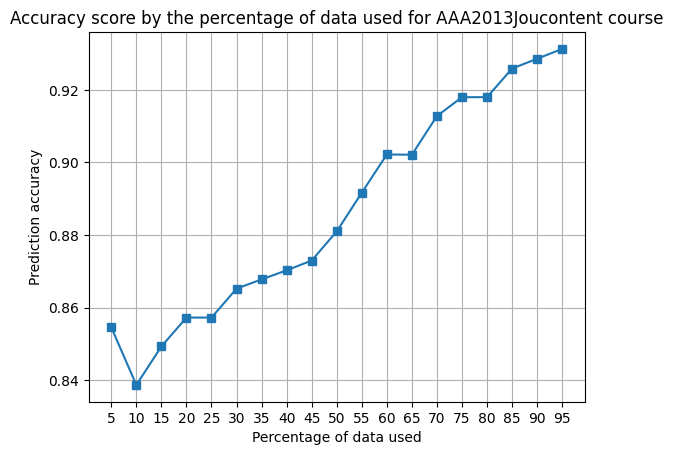

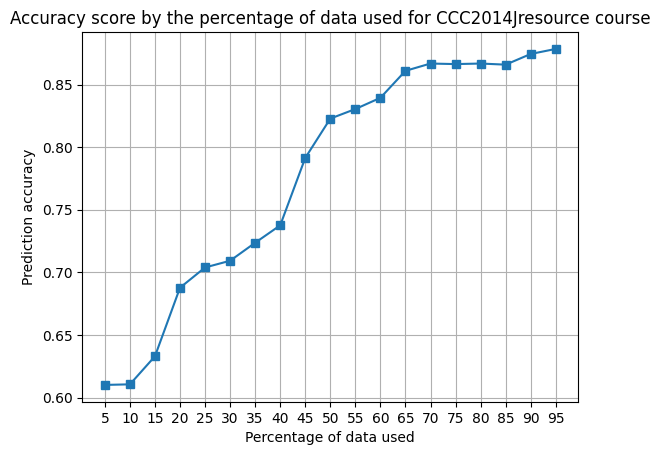

In [77]:
for index_slice in [
    ("AAA", "2013J", slice(None), "oucontent"),
    ("CCC", "2014J", slice(None), "resource"),
]:
    results = []
    y = click_stream.loc[index_slice, "final_result"].values
    for i in range(5, 100, 5):
        estimator = TimeSeriesForest(n_estimators=500)
        limit = round((click_stream.columns.shape[0] - 1) * i / 100)
        X = click_stream.loc[index_slice, click_stream.columns[:limit]].values
        scores = cross_val_score(estimator, X, y, cv=10, scoring="accuracy", n_jobs=-1)
        mean_score = np.mean(scores)
        results.append(mean_score)

    NAME = index_slice[0] + index_slice[1] + index_slice[3]
    pd.Series(results, index=range(5, 100, 5)).plot(
        title=f"Accuracy score by the percentage of data used for {NAME} course",
        xlabel="Percentage of data used",
        ylabel="Prediction accuracy",
        xticks=range(5, 100, 5),
        figsize=(10, 5),
        grid=True,
        marker="s",
    )
    plt.show()